## demo decam

This walkthrough uses the Burke et al. 2019 dataset, but superceeds the old Matterport Mask R-CNN implementation.

#### A few notes:

The data can be obtained following the links in the [old repository](https://github.com/burke86/astro_rcnn). The dataset directories should be re-named "test", "train", and "val".

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer
from detectron2.engine import SimpleTrainer
from detectron2.engine import HookBase
from typing import Dict, List, Optional
import detectron2.solver as solver
import detectron2.modeling as modeler
import detectron2.data as data
import detectron2.data.transforms as T
import detectron2.checkpoint as checkpointer
from detectron2.data import detection_utils as utils
import weakref
import copy
import torch
import time

from astrodet import astrodet as toolkit

In [2]:
# Print some versions so we know what works
print(torch.__version__)
print(detectron2.__version__)

1.7.1
0.3


In [3]:
# Prettify the plotting
from astrodet.astrodet import set_mpl_style
set_mpl_style()

In [4]:
dirpath = '/home/colinjb2' # Path to dataset
output_dir = './output'

dataset_names = ['train', 'test', 'val'] 

### Register Astro R-CNN dataset

In [5]:
from detectron2.structures import BoxMode
from astropy.io import fits
import glob

def get_astro_dicts(img_dir):
        
    # It's weird to call this img_dir
    set_dirs = sorted(glob.glob('%s/set_*' % img_dir))
    
    dataset_dicts = []
    
    # Loop through each set
    for idx, set_dir in enumerate(set_dirs):
        record = {}
        
        mask_dir = os.path.join(img_dir, set_dir, "masks.fits")
        filename = os.path.join(img_dir, set_dir, "img")
        
        # Open each FITS image
        with fits.open(mask_dir, memmap=False, lazy_load_hdus=False) as hdul:
            sources = len(hdul)
            height, width = hdul[0].data.shape
            data = [hdu.data/np.max(hdu.data) for hdu in hdul]
            category_ids = [hdu.header["CLASS_ID"] for hdu in hdul]
            
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        
        # Mask value thresholds per category_id
        thresh = [0.005 if i == 1 else 0.08 for i in category_ids]
        
        # Generate segmentation masks
        for i in range(sources):
            image = data[i]
            mask = np.zeros([height, width], dtype=np.uint8)
            # Create mask from threshold
            mask[:,:][image > thresh[i]] = 1
            # Smooth mask
            mask[:,:] = cv2.GaussianBlur(mask[:,:], (9,9), 2)
            
            # https://github.com/facebookresearch/Detectron/issues/100
            mask_new, contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []
            for contour in contours:
                x,y,w,h = cv2.boundingRect(contour)
                contour = contour.flatten().tolist()
                # segmentation.append(contour)
                if len(contour) > 4:
                    segmentation.append(contour)
            # No valid countors
            if len(segmentation) == 0:
                continue
            
            # Add to dict
            obj = {
                "bbox": [x, y, w, h],
                "area": w*h,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": segmentation,
                "category_id": category_ids[i] - 1,
            }
            objs.append(obj)
            
        record["annotations"] = objs
        dataset_dicts.append(record)
         
    return dataset_dicts


for i, d in enumerate(dataset_names):
    filenames_dir = os.path.join(dirpath,d)
    DatasetCatalog.register("astro_" + d, lambda: get_astro_dicts(filenames_dir))
    MetadataCatalog.get("astro_" + d).set(thing_classes=["star", "galaxy"], things_colors = ['blue', 'gray'])
astro_metadata = MetadataCatalog.get("astro_train")

### Custom image reader

In [6]:
def read_image(filename, normalize='lupton', stretch=5, Q=10, m=0, ceil_percentile=99.995, dtype=np.uint8):
    
    # Read image
    # TODO: Combine these files into one img_0, mask_0 ... in simulate.py
    g = fits.getdata(os.path.join(filename+'_g.fits'), memmap=False)
    r = fits.getdata(os.path.join(filename+'_r.fits'), memmap=False)
    z = fits.getdata(os.path.join(filename+'_z.fits'), memmap=False)
    
    # Contrast scaling / normalization
    I = (z + r + g)/3.0
    
    length, width = g.shape
    image = np.empty([length, width, 3], dtype=dtype)
    
    # Options for contrast scaling
    if normalize.lower() == 'lupton':
        z = z*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        r = r*np.arcsinh(stretch*Q*(I - m))/(Q*I)
        g = g*np.arcsinh(stretch*Q*(I - m))/(Q*I)
    elif normalize.lower() == 'zscore':
        Isigma = I*np.mean([np.nanstd(g), np.nanstd(r), np.nanstd(z)])
        z = (z - np.nanmean(z) - m)/Isigma
        r = (r - np.nanmean(r) - m)/Isigma
        g = (g - np.nanmean(g) - m)/Isigma
    elif normalize.lower() == 'linear':
        z = (z - m)/I
        r = (r - m)/I
        g = (g - m)/I
    else:
        print('Normalize keyword not recognized.')

    max_RGB = np.nanpercentile([z, r, g], ceil_percentile) * 2
    # avoid saturation
    r = r/max_RGB; g = g/max_RGB; z = z/max_RGB

    # Rescale to 0-255 for dtype=np.uint8
    max_dtype = np.iinfo(dtype).max
    r = r*max_dtype
    g = g*max_dtype
    z = z*max_dtype

    # 0-255 RGB image
    image[:,:,0] = z # R
    image[:,:,1] = r # G
    image[:,:,2] = g # B
    
    return image

### Visualize ground truth examples

In [7]:
dataset_dicts = {}
for i, d in enumerate(dataset_names):
    print(f'Loading {d}')
    dataset_dicts[d] = get_astro_dicts(os.path.join(dirpath, d))

Loading train
Loading test
Loading val


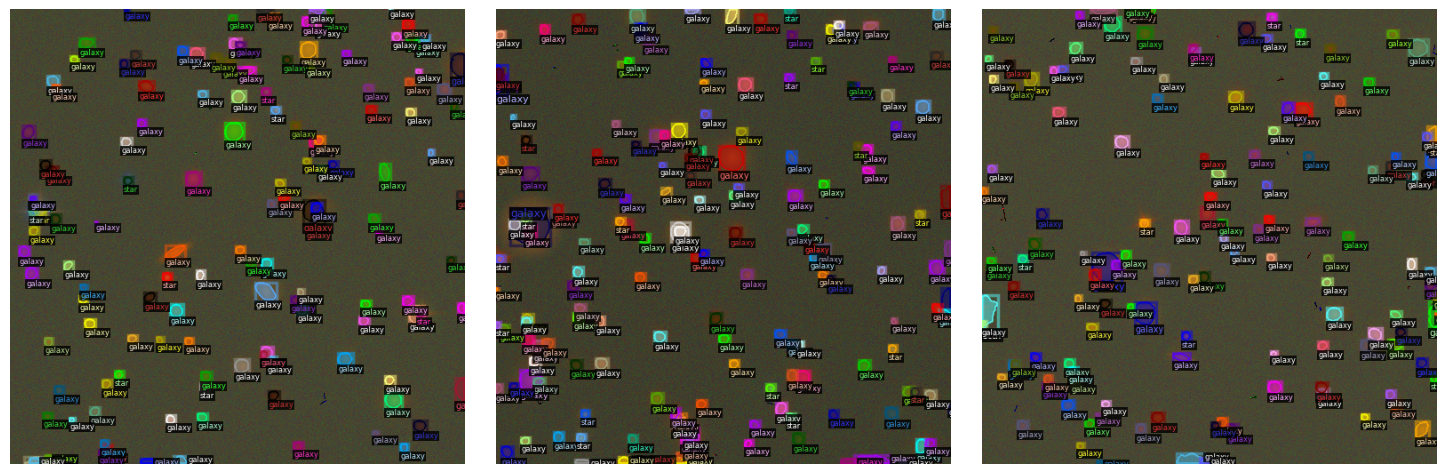

In [9]:
nsample = 3 # Number of example images to plot
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['train'], nsample)):
    # Use the Lupton scaling for better visualization
    img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
    visualizer = Visualizer(img, metadata=astro_metadata)
    # Plot the figures
    out = visualizer.draw_dataset_dict(d)
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

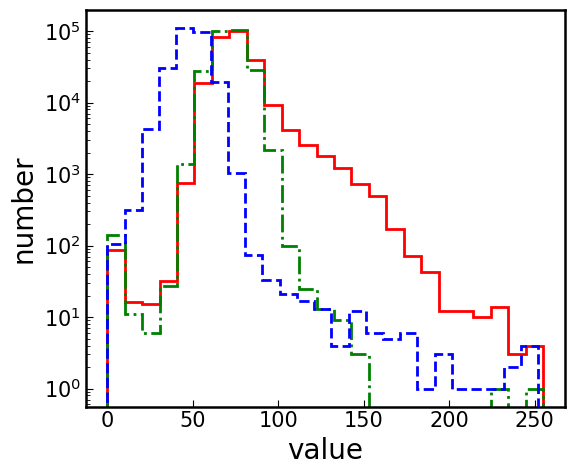

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
bins = 25
ax.hist(img[:,:,0].flatten(), histtype="step", bins=bins, log=True, color="r", lw=2, zorder=1);
ax.hist(img[:,:,1].flatten(), histtype="step", bins=bins, log=True, color="g", lw=2, linestyle='-.', zorder=2);
ax.hist(img[:,:,2].flatten(), histtype="step", bins=bins, log=True, color="b", lw=2, linestyle='dashed', zorder=3);
ax.set_xlabel('value', fontsize=20)
ax.set_ylabel('number', fontsize=20)
fig.tight_layout()

### Augmented Data

Only plot the bounding boxes for clarity

In [11]:
def train_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    
    image = read_image(dataset_dict["file_name"], **read_image_args)
    augs = T.AugmentationList([
        T.RandomRotation([-90, 90, 180], sample_style='choice'),
        T.RandomFlip(prob=0.5),
        T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
    }

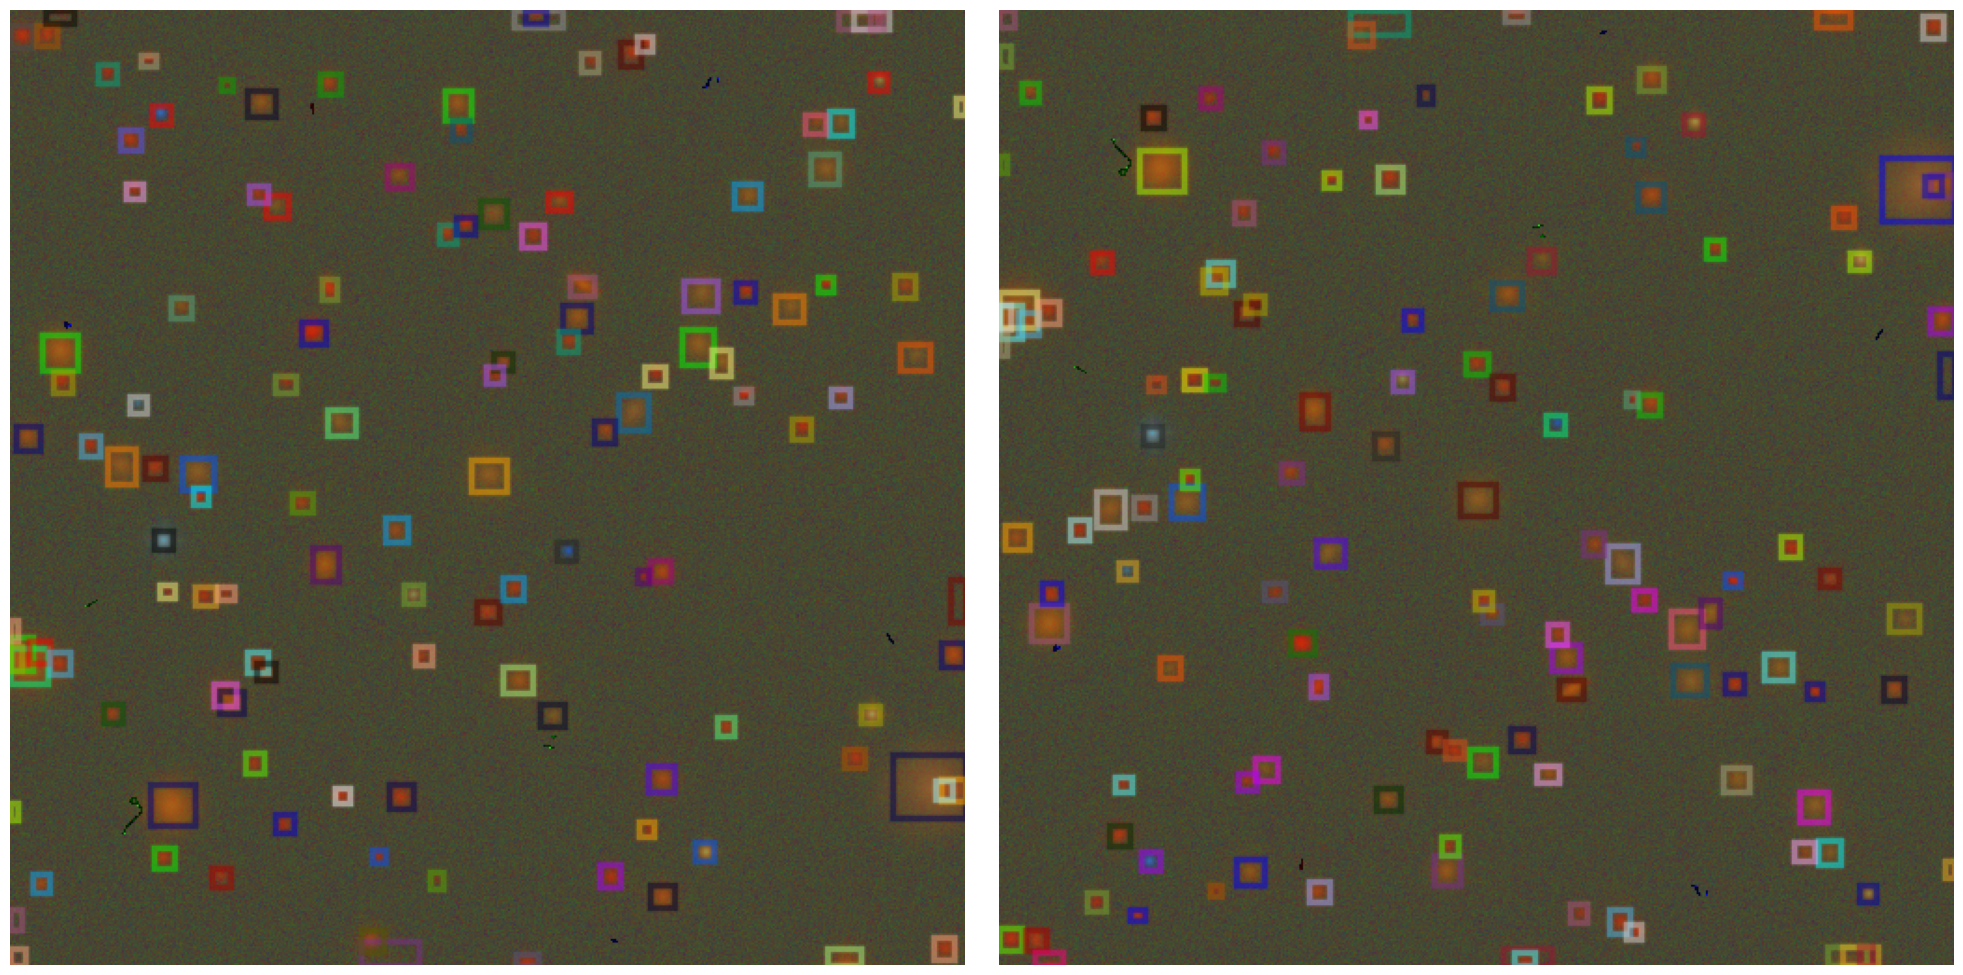

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10*2, 10))

dictionary = iter(dataset_dicts['train'])
d = next(dictionary)

img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
visualizer = Visualizer(img, metadata=astro_metadata, scale=1)
# Get the ground truth boxes
gt_boxes = np.array([a['bbox'] for a in d['annotations']])
# Convert to the mode visualizer expects
gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
out = visualizer.overlay_instances(boxes=gt_boxes)
axs[0].imshow(out.get_image())
axs[0].axis('off')

aug_d = train_mapper(d, normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
img_aug = aug_d["image_shaped"]
visualizer = Visualizer(img_aug, metadata=astro_metadata, scale=1)
# Convert to the mode visualizer expects
out = visualizer.overlay_instances(boxes=aug_d['instances'].gt_boxes)
axs[1].imshow(out.get_image())
axs[1].axis('off')
fig.tight_layout()
fig.show()

### Prepare For Training

...

In [13]:
init_coco_weights = True # Start training from MS COCO weights

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")) # Get model structure
cfg.DATASETS.TRAIN = ("astro_train") # Register Metadata
cfg.DATASETS.TEST = ("astro_val") # Config calls this TEST, but it should be the val dataset
cfg.TEST.EVAL_PERIOD = 40
cfg.DATALOADER.NUM_WORKERS = 1
if init_coco_weights:
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")  # Initialize from MS COCO
else:
    cfg.MODEL.WEIGHTS = os.path.join(output_dir, 'model_temp.pth')  # Initialize from a local weights
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001   # pick a good LR -- start from 0.005
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.MAX_ITER = 100    # for DefaultTrainer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.OUTPUT_DIR = output_dir
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
saveHook = toolkit.SaveHook()
saveHook.set_output_name("model_temp")
hookList = [saveHook]

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
model = modeler.build_model(cfg)
optimizer = solver.build_optimizer(cfg, model)
loader = data.build_detection_train_loader(cfg, mapper=train_mapper)
print(type(optimizer))

[11/28 23:01:19 d2.data.build]: Removed 0 images with no usable annotations. 250 images left.
[11/28 23:01:19 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    star    | 3356         |   galaxy   | 30750        |
|            |              |            |              |
|   total    | 34106        |            |              |
[11/28 23:01:19 d2.data.build]: Using training sampler TrainingSampler
[11/28 23:01:19 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[11/28 23:01:19 d2.data.common]: Serialized dataset takes 4.07 MiB
<class 'torch.optim.sgd.SGD'>


In [13]:
# Hack if you get SSL certificate error 
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:
trainer = toolkit.AstroTrainer(model, loader, optimizer, cfg)
trainer.register_hooks(hookList)
#trainer.set_period(4) # print loss every n iterations
trainer.train(0, 400)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (3, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (8, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[11/28 23:01:19 d2.engine.train_loop]: Starting training from iteration 0


/home/colinjb2/.conda/envs/opence-v1.1.1-colinjb2/lib/python3.6/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/apps/anaconda3/envs/opence-v.1.1.1/conda-bld/pytorch-base_1611680481078/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


{'loss_cls': tensor(1.2673, device='cuda:0', grad_fn=<MulBackward0>), 'loss_box_reg': tensor(0.3702, device='cuda:0', grad_fn=<MulBackward0>), 'loss_mask': tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_cls': tensor(3.6377, device='cuda:0', grad_fn=<MulBackward0>), 'loss_rpn_loc': tensor(0.4821, device='cuda:0', grad_fn=<MulBackward0>)}
{'loss_cls': tensor(1.0264, device='cuda:0', grad_fn=<MulBackward0>), 'loss_box_reg': tensor(0.4622, device='cuda:0', grad_fn=<MulBackward0>), 'loss_mask': tensor(0.6927, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_cls': tensor(2.0445, device='cuda:0', grad_fn=<MulBackward0>), 'loss_rpn_loc': tensor(0.4454, device='cuda:0', grad_fn=<MulBackward0>)}
{'loss_cls': tensor(0.8171, device='cuda:0', grad_fn=<MulBackward0>), 'loss_box_reg': tensor(0.6188, device='cuda:0', grad_fn=<MulBackward0>), 'loss_mask': tensor(0.6876, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>

### Plot The Loss

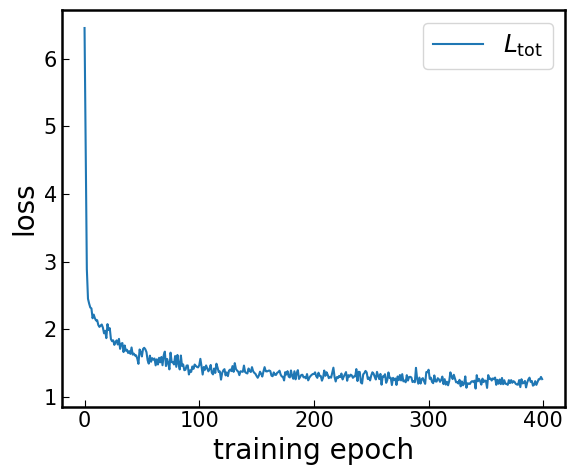

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r'$L_{\rm{tot}}$')
ax.legend(loc='upper right')
ax.set_xlabel('training epoch', fontsize=20)
ax.set_ylabel('loss', fontsize=20)
fig.tight_layout()

In [54]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output --host localhost

### Inference

In [16]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_temp.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

total instances: 129
detected instances: 137

total instances: 138
detected instances: 136

total instances: 141
detected instances: 136



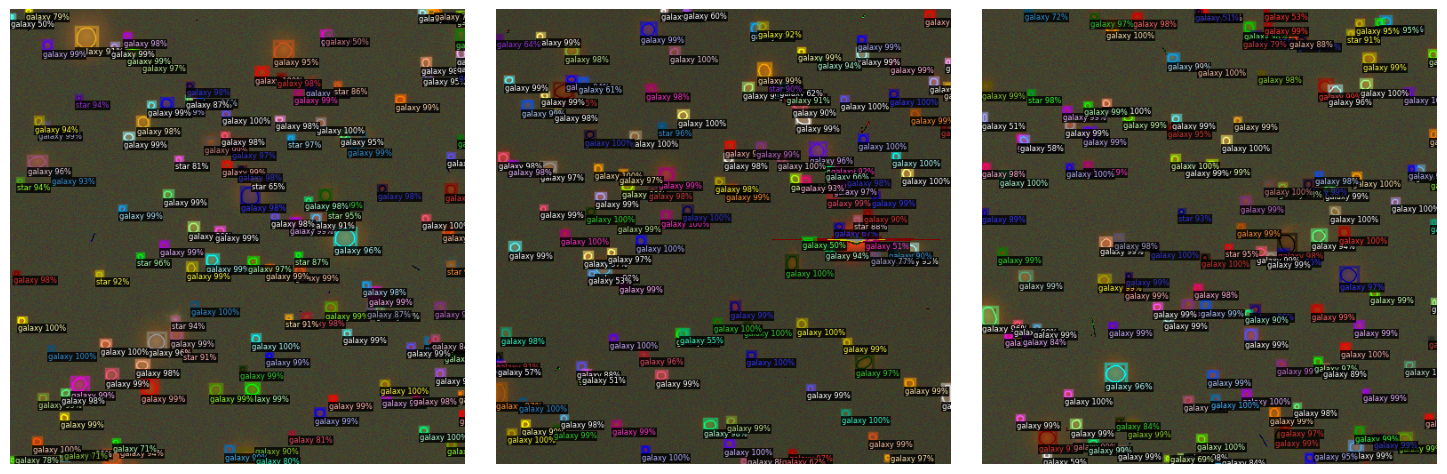

In [18]:
from detectron2.utils.visualizer import ColorMode

nsample = 3
fig, axs = plt.subplots(1, nsample, figsize=(5*nsample, 5))

for i, d in enumerate(random.sample(dataset_dicts['test'], nsample)):
    img = read_image(d["file_name"], normalize="lupton", stretch=5, Q=1, ceil_percentile=99.5)
    outputs = predictor(img)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    print('total instances:', len(d['annotations']))
    print('detected instances:', len(outputs['instances'].pred_boxes))
    print('')
    
    v = Visualizer(img,
                   metadata=astro_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    axs[i].imshow(out.get_image())
    axs[i].axis('off')
    fig.tight_layout()
    fig.show()

### Evaluate

In [19]:
def test_mapper(dataset_dict, **read_image_args):

    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below

    image = read_image(dataset_dict["file_name"], *read_image_args)
    augs = T.AugmentationList([
        #T.RandomRotation([-90, 90, 180], sample_style='choice'),
        #T.RandomFlip(prob=0.5),
        #T.Resize((512,512))
    ])
    # Data Augmentation
    auginput = T.AugInput(image)
    # Transformations to model shapes
    transform = augs(auginput)
    image = torch.from_numpy(auginput.image.copy().transpose(2, 0, 1))
    annos = [
        utils.transform_instance_annotations(annotation, [transform], image.shape[1:])
        for annotation in dataset_dict.pop("annotations")
    ]
    return {
       # create the format that the model expects
        "image": image,
        "image_shaped": auginput.image,
        "height": 512,
        "width": 512,
        "image_id": dataset_dict["image_id"],
        "instances": utils.annotations_to_instances(annos, image.shape[1:]),
        "annotations": annos
    }

In [20]:
# All of the astro_train_coco... stuff gets generated here...
# only keep last_checkpoint and model_temp.pth files really.

In [21]:
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader

# NOTE: New version has max_dets_per_image argument in default COCOEvaluator
evaluator = toolkit.COCOEvaluatorRecall("astro_val", use_fast_impl=True, output_dir=cfg.OUTPUT_DIR)

# First run with train_mapper to generate .json files consistent with training format
# Then run with test_mapper to get AP scores (doesn't work with augmentation mapper)
train_loader = build_detection_test_loader(dataset_dicts['val'], mapper=train_mapper)
test_loader = build_detection_test_loader(dataset_dicts['val'], mapper=test_mapper)

[11/28 23:06:03 d2.evaluation.coco_evaluation]: 'astro_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[11/28 23:06:03 d2.data.datasets.coco]: Converting annotations of dataset 'astro_val' to COCO format ...)
[11/28 23:08:47 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/28 23:08:51 d2.data.datasets.coco]: Conversion finished, #images: 250, #annotations: 34106
[11/28 23:08:51 d2.data.datasets.coco]: Caching COCO format annotations at './output/astro_val_coco_format.json' ...
[11/28 23:08:54 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[11/28 23:08:54 d2.data.common]: Serialized dataset takes 4.07 MiB
[11/28 23:08:54 d2.data.common]: Serializing 250 elements to byte tensors and concatenating them all ...
[11/28 23:08:54 d2.data.common]: Serialized dataset takes 4.07 MiB


In [22]:
results = inference_on_dataset(predictor.model, test_loader, evaluator)

[11/28 23:08:54 d2.evaluation.evaluator]: Start inference on 250 images
[11/28 23:08:58 d2.evaluation.evaluator]: Inference done 11/250. 0.1621 s / img. ETA=0:01:15
[11/28 23:09:03 d2.evaluation.evaluator]: Inference done 26/250. 0.1629 s / img. ETA=0:01:15
[11/28 23:09:08 d2.evaluation.evaluator]: Inference done 41/250. 0.1630 s / img. ETA=0:01:10
[11/28 23:09:13 d2.evaluation.evaluator]: Inference done 55/250. 0.1629 s / img. ETA=0:01:07
[11/28 23:09:18 d2.evaluation.evaluator]: Inference done 70/250. 0.1629 s / img. ETA=0:01:01
[11/28 23:09:24 d2.evaluation.evaluator]: Inference done 85/250. 0.1628 s / img. ETA=0:00:56
[11/28 23:09:29 d2.evaluation.evaluator]: Inference done 100/250. 0.1627 s / img. ETA=0:00:51
[11/28 23:09:34 d2.evaluation.evaluator]: Inference done 115/250. 0.1627 s / img. ETA=0:00:46
[11/28 23:09:39 d2.evaluation.evaluator]: Inference done 130/250. 0.1628 s / img. ETA=0:00:40
[11/28 23:09:44 d2.evaluation.evaluator]: Inference done 145/250. 0.1628 s / img. ETA=0:

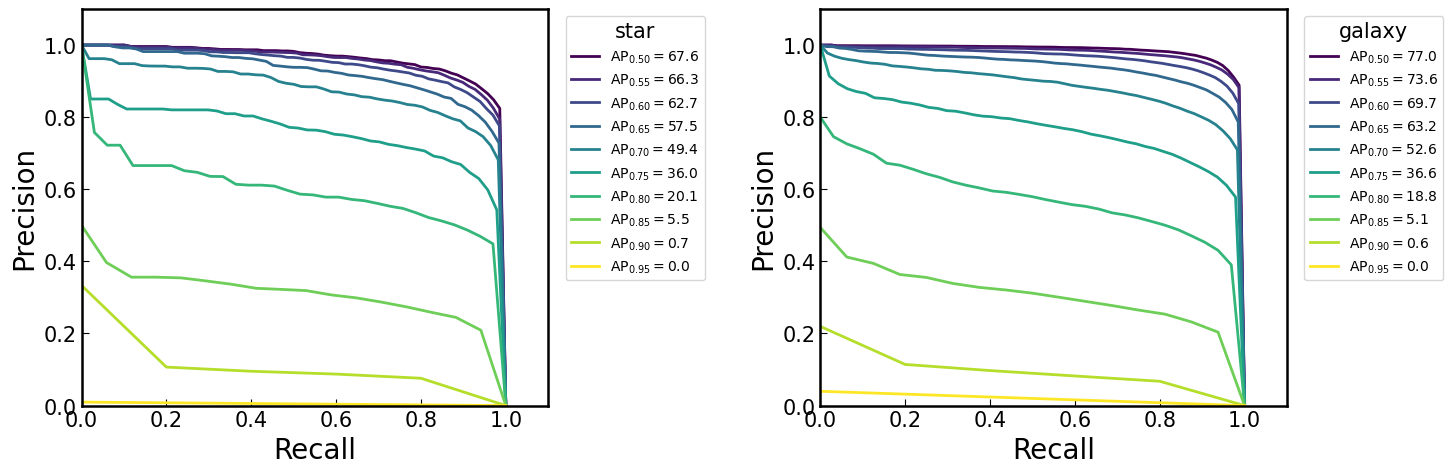

In [29]:
ap_type = 'bbox' # Which type of precision/recall to use? 'segm', or 'bbox'
cls_names = ['star', 'galaxy']

results_per_category = results[ap_type]['results_per_category']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

ious = np.linspace(0.50,0.95,10)
colors = plt.cm.viridis(np.linspace(0,1,len(ious)))

# Plot precision recall
for j, precision_class in enumerate(results_per_category):
    precision_shape = np.shape(precision_class)
    for i in range(precision_shape[0]):
        # precision has dims (iou, recall, cls, area range, max dets)
        # area range index 0: all area ranges
        # max dets index -1: typically 100 per image
        p_dat = precision_class[i, :, j, 0, -1]
        # Hide vanishing precisions
        mask = (p_dat > 0)
        # Only keep first occurance of 0 value in array
        mask[np.cumsum(~mask) == 1] = True
        p = p_dat[mask]
        # Recall points
        r = np.linspace(0, 1, len(p)) # Recall is always defined from 0 to 1 for these plots, I think
        dr = np.diff(np.linspace(0, 1, len(p_dat)))[0] # i think
        # Plot
        iou = np.around(ious[i], 2)
        AP = 100*np.sum(p*dr)
        axs[j].plot(r, p, label=r'${\rm{AP}}_{%.2f} = %.1f$' % (iou, AP), color=colors[i], lw=2) # use a viridis color scheme
        axs[j].set_xlabel('Recall', fontsize=20)
        axs[j].set_ylabel('Precision', fontsize=20)
        axs[j].set_xlim(0, 1.1)
        axs[j].set_ylim(0, 1.1)
        axs[j].legend(fontsize=10, title=f'{cls_names[j]}', bbox_to_anchor=(1.35, 1.0))
        
fig.tight_layout()